# 2012 Federal Election Commission Database

> The US Federal Election Commission publishes data on contributions to political campaigns. This includes contributor names, occupation and employer, address, and contribution amount. An interesting dataset is from the 2012 US presidential election. This file is a 150 MB CSV file. 

## 1 Load The Data and Basic Data Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fec = pd.read_csv('P00000001-ALL.csv', low_memory = False)
fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
cmte_id              1001731 non-null object
cand_id              1001731 non-null object
cand_nm              1001731 non-null object
contbr_nm            1001731 non-null object
contbr_city          1001712 non-null object
contbr_st            1001727 non-null object
contbr_zip           1001620 non-null object
contbr_employer      988002 non-null object
contbr_occupation    993301 non-null object
contb_receipt_amt    1001731 non-null float64
contb_receipt_dt     1001731 non-null object
receipt_desc         14166 non-null object
memo_cd              92482 non-null object
memo_text            97770 non-null object
form_tp              1001731 non-null object
file_num             1001731 non-null int64
dtypes: float64(1), int64(1), object(14)
memory usage: 122.3+ MB


In [3]:
# A sample record in the DataFrame:
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                          50
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [4]:
# Explore the unique candidates

unique_cands = fec.cand_nm.unique()
unique_cands

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

From the dataset, we noticed that there are no political party affiliations in the data, so this would be useful to add. We implemented __map()__ method.

In [5]:
parties = {'Bachmann, Michelle': 'Republican',
'Cain, Herman': 'Republican',
'Gingrich, Newt': 'Republican',
'Huntsman, Jon': 'Republican',
'Johnson, Gary Earl': 'Republican',
'McCotter, Thaddeus G': 'Republican',
'Obama, Barack': 'Democrat',
'Paul, Ron': 'Republican',
'Pawlenty, Timothy': 'Republican',
'Perry, Rick': 'Republican',
"Roemer, Charles E. 'Buddy' III": 'Republican',
'Romney, Mitt': 'Republican',
'Santorum, Rick': 'Republican'}

fec['party'] = fec.cand_nm.map(parties)
fec['party'].value_counts()

Democrat      593746
Republican    407985
Name: party, dtype: int64

Firstly, there exists both contributions and refunds. So, we would only focus on the positive donations. 

In [6]:
(fec.contb_receipt_amt >0).value_counts()

True     991475
False     10256
Name: contb_receipt_amt, dtype: int64

In [7]:
fec = fec[fec.contb_receipt_amt>0]


As we all knew, only Barack Obama and Mitt Romney were two main two candidates, we prepare a subset that people just made contributions to their campaigns.

In [8]:
fec_new = fec[fec.cand_nm.isin(['Obama, Barack', 'Romney, Mitt'])]

## 2. Donation Statistics by Occupation and Employer

In [9]:
# Show the top 10 total number of donations by occupation
fec.contbr_occupation.value_counts()[0:10]

RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: contbr_occupation, dtype: int64

In [10]:
# Map the data which requested but was not provided
occ_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'INFORMATION REQUESTED (BEST EFFORTS)' : 'NOT PROVIDED',
'C.E.O.': 'CEO'
}

# If no mapping provided, return x
f = lambda x: occ_mapping.get(x,x)
fec.contbr_occupation = fec.contbr_occupation.map(f)

# Do the same thing for employers

emp_mapping = {
'INFORMATION REQUESTED PER BEST EFFORTS' : 'NOT PROVIDED',
'INFORMATION REQUESTED' : 'NOT PROVIDED',
'SELF' : 'SELF-EMPLOYED',
'SELF EMPLOYED' : 'SELF-EMPLOYED',
}

f = lambda x: emp_mapping.get(x, x)
fec.contbr_employer = fec.contbr_employer.map(f)

Now, we would like to use  __pivot_table__ method to aggregate the data by party and occupation, then filter down to the subset that donated exceed $2 million overall


In [11]:
by_occupation = fec.pivot_table('contb_receipt_amt', index = 
                               'contbr_occupation', 
                               columns = 'party', aggfunc = sum)

over_2mm = by_occupation[by_occupation.sum(1)> 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7.477194e+06
CEO,2074974.79,4.211041e+06
CONSULTANT,2459912.71,2.544725e+06
ENGINEER,951525.55,1.818374e+06
EXECUTIVE,1355161.05,4.138850e+06
HOMEMAKER,4248875.80,1.363428e+07
INVESTOR,884133.00,2.431769e+06
LAWYER,3160478.87,3.912243e+05
MANAGER,762883.22,1.444532e+06


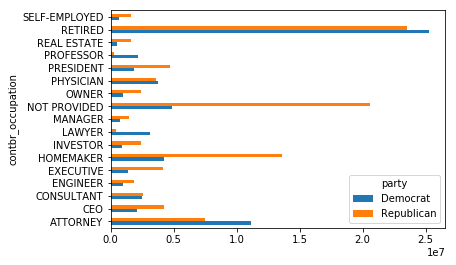

In [12]:
# Bar plot visulization
over_2mm.plot(kind = 'barh')
plt.show()

Next step, we would like to investigate what are the top 5 donor occupations or top companies that donated to Obama and Romney. 

In [13]:
def get_top_amounts(group, key, n = 5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    
    return totals.nlargest(n)


# Grouped by occupations
grouped_occupation = fec_new.groupby('cand_nm').apply(get_top_amounts, 'contbr_occupation')
grouped_occupation   

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
Name: contb_receipt_amt, dtype: float64

In [14]:
# Grouped by employer
grouped_employer = fec_new.groupby('cand_nm').apply(get_top_amounts, 'contbr_employer')
grouped_employer

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                              7409860.98
               STUDENT                                     496490.94
Name: contb_receipt_amt, dtype: float64

## 3. Contribution Size Investigation

In [15]:
import numpy as np

In [16]:
bins = np.array([0, 1, 10, 100, 1000, 10000,100000, 1000000, 10000000])
labels = pd.cut(fec_new.contb_receipt_amt, bins)
labels[0:10]

411      (10, 100]
412    (100, 1000]
413    (100, 1000]
414      (10, 100]
415      (10, 100]
416      (10, 100]
417    (100, 1000]
418      (10, 100]
419    (100, 1000]
420      (10, 100]
Name: contb_receipt_amt, dtype: category
Categories (8, interval[int64]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [18]:
# We can group the data for Obama and Romney by name and bin label 
# to get a histograme by donation size

grouped = fec_new.groupby(['cand_nm', labels])
grouped.size().unstack(0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493.0,77.0
"(1, 10]",40070.0,3681.0
"(10, 100]",372280.0,31853.0
"(100, 1000]",153991.0,43357.0
"(1000, 10000]",22284.0,26186.0
"(10000, 100000]",2.0,1.0
"(100000, 1000000]",3.0,NaN
"(1000000, 10000000]",4.0,NaN


The above table shows that Obama received a significantly larger number of small donations than Romney. We also sum the contribtuion amounts and normalize within buckets to visulize percentage of total donations of each size by candidate.

In [19]:
bucket_sums = grouped.contb_receipt_amt.sum().unstack(0)
normed_sums = bucket_sums.div(bucket_sums.sum(axis = 1), axis = 0)
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,NaN
"(1000000, 10000000]",1.000000,NaN


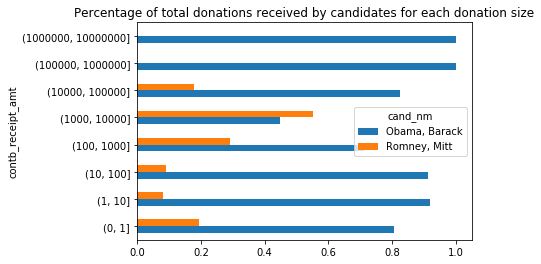

In [21]:
# Show a bar plot of the donation size
normed_sums.plot(title = 'Percentage of total donations received by candidates for each donation size',
                 kind = 'barh')
plt.show()

## 4. Donation Statistics by State

In [22]:
grouped = fec_new.groupby(['cand_nm', 'contbr_st'])
totals = grouped.contb_receipt_amt.sum().unstack(0).fillna(0)
totals = totals[totals.sum(1) > 100000]
totals[0:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [23]:
# Relative percentage of total donations by state for each candidate
percent = totals.div(totals.sum(1), axis =0)
percent[0:10]

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224


In [36]:
percent_reset = percent.unstack().reset_index()


In [37]:
percent_reset.head(10)

,cand_nm,contbr_st,0
0,"Obama, Barack",AK,0.765778
1,"Obama, Barack",AL,0.507390
2,"Obama, Barack",AR,0.772902
3,"Obama, Barack",AZ,0.443745
4,"Obama, Barack",CA,0.679498
5,"Obama, Barack",CO,0.585970
6,"Obama, Barack",CT,0.371476
7,"Obama, Barack",DC,0.810113
8,"Obama, Barack",DE,0.802776
9,"Obama, Barack",FL,0.467417


In [38]:
percent_obama = percent_reset[percent_reset['cand_nm'] == 'Obama, Barack']

In [39]:
percent_romney = percent_reset[percent_reset['cand_nm'] == 'Romney, Mitt']

In [45]:
percent_obama = percent_obama.rename(columns = {0:'percent'})
percent_obama.head()

,cand_nm,contbr_st,percent
0,"Obama, Barack",AK,0.765778
1,"Obama, Barack",AL,0.507390
2,"Obama, Barack",AR,0.772902
3,"Obama, Barack",AZ,0.443745
4,"Obama, Barack",CA,0.679498


In [ ]:
percent_romney = percent_romney.rename(columns = {0:'percent'})
percent_romney.head()